In [1]:
from __future__ import print_function, division
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# for the model
import bms
from bms.signals.functions import Ramp, Sinus, SignalFunction
from bms.blocks.continuous import Sum, Subtraction, FunctionBlock, ODE, FunctionBlock
from scipy import signal

# for loading bars
try:
    from tqdm import tqdm_notebook as tqdm
except:
    from tqdm import tqdm

# for the eeg analysis
import mne
import ssvepy
%matplotlib inline

### Model

__Schematic__ from the original model:

![](./img/model.png)


__Model__ with variable names

```
inp_sig   inp_noise
  |       /
  |     _/
inp_sum
  |
nmda1_input
  |
nmda1    gaba1 <----------
  |       |              |
  |       |              |
  \       /              |
receptor_sum             |
    |                    |
excitatory_potential     |
    |                    |
excitatory_cell          |
    |                    |
excitatory_output        |
    |                    |
   nmda2                 |
    |                    |
inhibitory_potential     |
    |                    |
inhibitory_cell          |
    |                    |
inhibitory_output        |
    |                    |
    ----------------------
```

### Define the dynamic system model

We'll define a block model system using `BMSpy`, and run it many times for different amounts of inhibitory gain.

In [2]:
t_trial = 10  # time of trial, seconds
t_discard = 2  # time we'll wait for transients
frequency = 256  # frequency of recording

inhibitory_gains = np.linspace(0, 12, 41)

inhibitory_potentials = []
excitatory_potentials = []

for inhibitory_gain in tqdm(inhibitory_gains):
    # create the two input components
    inp_sig = SignalFunction(
        'inp_sig', lambda t: 120 * signal.square(t * 5 * 2 * np.pi))
    inp_noise = SignalFunction(
        'inp_noise', lambda t: 550 + 10 * (np.random.rand() - 0.5))

    # sum the input
    nmda1_input = bms.Variable('nmda1_input')
    inp_sum = Sum([inp_sig, inp_noise], nmda1_input)

    # excitatory cell receptor outputs
    nmda1_output = bms.Variable('nmda1_output')
    gaba1_output = bms.Variable('gaba1_output')
    # excitatory cell receptors
    nmda1 = ODE(nmda1_input, nmda1_output, [880], [33275, 660, 1])

    # combine the inputs
    excitatory_potential = bms.Variable('excitatory_potential')
    receptor_sum = Subtraction(nmda1_output, gaba1_output, excitatory_potential)

    # output of the excitatory cell
    excitatory_output = bms.Variable('excitatory_output')
    excitatory_cell = FunctionBlock(excitatory_potential, excitatory_output,
                                    lambda p: 32 * 50 * (1 + np.exp((p - 7) / (-2))) ** (-1))

    # input to the inhibitory cell: NMDA receptor
    inhibitory_potential = bms.Variable('inhibitory_potential')
    nmda2 = ODE(excitatory_output, inhibitory_potential, [880], [33275, 660, 1])

    # output of the inhibitory cell
    inhibitory_output = bms.Variable('inhibitory_output')
    inhibitory_cell = FunctionBlock(inhibitory_potential, inhibitory_output,
                                    lambda p: inhibitory_gain * 50 * (1 + np.exp((p - 7) / (-2))) ** (-1))

    # inhibitory feedback
    gaba1 = ODE(inhibitory_output, gaba1_output, [880], [1512.5, 82.5, 1])
    
    # define the model
    model = bms.DynamicSystem(t_trial + t_discard, frequency * (t_trial + t_discard),
                              [inp_sum, # input (stimulation)
                               gaba1, nmda1, receptor_sum, excitatory_cell, # excitatory cell
                               nmda2, inhibitory_cell, gaba1] # inhibitory cell
                              )
    # run the model
    model.Simulate()
    
    # collect the output
    inhibitory_potentials.append(inhibitory_potential.values[-t_trial*frequency:])
    excitatory_potentials.append(excitatory_potential.values[-t_trial*frequency:])


Widget Javascript not detected.  It may not be installed or enabled properly.


### Use EEG analysis tools to look at this

In [3]:
# create a fake info structure
info = mne.create_info(['Oz'], 256, ch_types='eeg')

# turn into a fake data structure
raws = [mne.io.RawArray(data.reshape(1, data.size), info) for data in excitatory_potentials]

# turn into "epoched" data
events = np.array([[0, 0, 1]])
event_id = {'on': 1}
tmin, tmax = 0, 8
epochs = [
    mne.Epochs(raw, events=events, event_id = event_id, tmin=tmin, tmax=tmax)
    for raw in tqdm(raws)
]

# use ssvepy to analyse the harmonic and subharmonic frequencies all at once
ssveps = [ssvepy.Ssvep(epoch, [5.0], fmin=1, fmax=50, compute_subharmonics=True)
          for epoch in tqdm(epochs)]

Creating RawArray with float64 data, n_channels=1, n_times=2560
    Range : 0 ... 2559 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=2560
    Range : 0 ... 2559 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=2560
    Range : 0 ... 2559 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=2560
    Range : 0 ... 2559 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=2560
    Range : 0 ... 2559 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=2560
    Range : 0 ... 2559 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=2560
    Range : 0 ... 2559 =      0.000 ...     9.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=2560
    Range : 0 ... 2559 =      0.000 ...     9.996 secs

Widget Javascript not detected.  It may not be installed or enabled properly.


1 matching events found
0 projection items activated
1 matching events found
0 projection items activated
1 matching events found
0 projection items activated
1 matching events found
0 projection items activated
1 matching events found
0 projection items activated
1 matching events found
0 projection items activated
1 matching events found
0 projection items activated
1 matching events found
0 projection items activated
1 matching events found
0 projection items activated
1 matching events found
0 projection items activated
1 matching events found
0 projection items activated
1 matching events found
0 projection items activated
1 matching events found
0 projection items activated
1 matching events found
0 projection items activated
1 matching events found
0 projection items activated
1 matching events found
0 projection items activated
1 matching events found
0 projection items activated
1 matching events found
0 projection items activated
1 matching events found
0 projection items act

Widget Javascript not detected.  It may not be installed or enabled properly.


Loading data for 1 events and 2049 original time points ...
0 bad epochs dropped
Loading data for 1 events and 2049 original time points ...
0 bad epochs dropped
Loading data for 1 events and 2049 original time points ...
0 bad epochs dropped
Loading data for 1 events and 2049 original time points ...
0 bad epochs dropped
Loading data for 1 events and 2049 original time points ...
0 bad epochs dropped
Loading data for 1 events and 2049 original time points ...
0 bad epochs dropped
Loading data for 1 events and 2049 original time points ...
0 bad epochs dropped
Loading data for 1 events and 2049 original time points ...
0 bad epochs dropped
Loading data for 1 events and 2049 original time points ...
0 bad epochs dropped
Loading data for 1 events and 2049 original time points ...
0 bad epochs dropped
Loading data for 1 events and 2049 original time points ...
0 bad epochs dropped
Loading data for 1 events and 2049 original time points ...
0 bad epochs dropped
Loading data for 1 events an

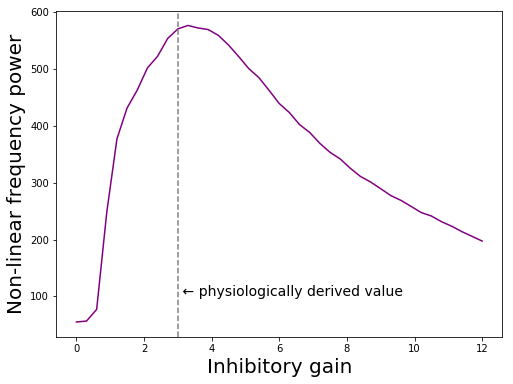

In [11]:
total_harmonics = np.array([ssvep.harmonic.power.sum() for ssvep in ssveps])
total_subharmonics = np.array([ssvep.subharmonic.power.sum() for ssvep in ssveps])

plt.figure(figsize=(8, 6))
plt.plot(inhibitory_gains, total_harmonics + total_subharmonics, color='purple')
plt.axvline(3, color='gray', linestyle='--')
plt.xlabel('Inhibitory gain', fontsize=20)
plt.ylabel('Non-linear frequency power', fontsize=20)
plt.text(3, 100, ' ← physiologically derived value', fontsize=14)
plt.savefig('harmonic-vs-inhibition.pdf', transparent=True)
plt.show()

# plt.plot(inhibitory_gains, total_subharmonics)
# plt.axvline(3, color='gray', linestyle='--')
# plt.show()
